In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

c:\Users\jaesc2\GitHub\skforecast
0.20.0


In [2]:
from skforecast.recursive import ForecasterStats
from skforecast.stats import Arar, Arima, Sarimax, Ets

import numpy as np
import pandas as pd
import skforecast
from skforecast.stats import Sarimax, Arima
from skforecast.recursive import ForecasterStats
from skforecast.model_selection import TimeSeriesFold, backtesting_stats
from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset

from aeon.forecasting.stats import ARIMA as ARIMA_aeon
# from statsforecast import StatsForecast
# from statsforecast.models import ARIMA as ARIMA_statsforecast
import matplotlib.pyplot as plt
import timeit

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
print(f"skforecast version: {skforecast.__version__}")

skforecast version: 0.20.0


Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


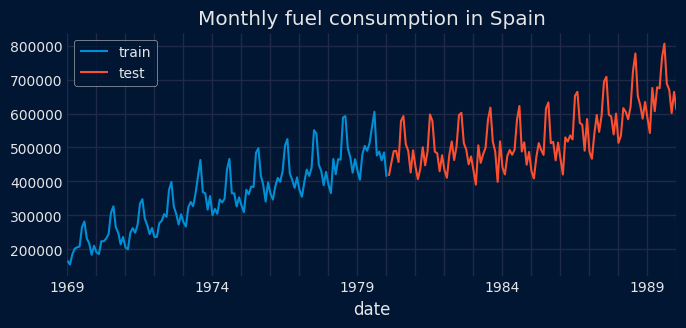

In [3]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=True, verbose=False)
data = data[['Fecha', 'Gasolinas']]
data = data.rename(columns={'Fecha': 'date', 'Gasolinas': 'y'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.loc[:'1990-01-01 00:00:00', ['y']]
data['month'] = data.index.month
data = pd.get_dummies(data, columns=['month'], prefix='month', drop_first=False, dtype=float)
data.head(3)

# Train-test dates
# ======================================================================================
set_dark_theme()
end_train = '1980-01-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

In [4]:
estimator_list = [
    Arima(
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1),
        m = 12
    ),
    Arima(
        order=(1, 2, 1),
        seasonal_order=(1, 1, 1),
        m = 12
    ),
    Sarimax(
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 12)
    ),
    Ets(),
    Arar()

]



forecaster = ForecasterStats(
                estimator = estimator_list,
            )
forecaster

=============== 
ForecasterStats 
=============== 
Estimators: ['skforecast.Arima', 'skforecast.Arima_2', 'skforecast.Sarimax', 'skforecast.Ets', 'skforecast.Arar'] 
Series name: None 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Estimator parameters: 
    skforecast.Arima: 
        {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1), 'm': 12, 'include_mean':
        True, 'transform_pars': True, 'method': 'CSS-ML', 'n_cond': None,
        'SSinit': 'Gardner1980', 'optim_method': 'BFGS', 'optim_kwargs':
        {'maxiter': 1000}, 'kappa': 1000000.0}
    skforecast.Arima_2: 
        {'order': (1, 2, 1), 'seasonal_order': (1, 1, 1), 'm': 12, 'include_mean':
        True, 'transform_pars': True, 'method': 'CSS-ML', 'n_cond': None,
        'SSinit': 'Gardner1980', 'optim_method': 'BFGS', 'optim_kwargs':
        {'maxiter': 1000}, 'kappa': 1000000.0}
    skforecast.Sarimax: 
        {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 12), 'trend': None,
        'measurement_error': False, 'time_varying_regression': False,
        'mle_regression': True, 'simple_differencing': False,
        'enforce_stationarity': True, 'enforce_invertibility': True,
        'hamilton_representation': False, 'concentrate_scale': False,
        'trend_offset': 1, 'use_exact_diffuse': False, 'dates': None,
        'freq': None, 'missing': 'none', 'validate_specification': True,
        'method': 'lbfgs', 'maxiter': 50, 'start_params': None, 'disp':
        False, 'sm_init_kwargs': {}, 'sm_fit_kwargs': {},
        'sm_predict_kwargs': {}}
    skforecast.Ets: 
        {'m': 1, 'model': 'ZZZ', 'damped': None, 'alpha': None, 'beta': None,
        'gamma': None, 'phi': None, 'seasonal': True, 'trend': None,
        'allow_multiplicative': True, 'allow_multiplicative_trend': False}
    skforecast.Arar: {'max_ar_depth': None, 'max_lag': None, 'safe': True} 
fit_kwargs: None 
Creation date: 2026-01-13 16:15:16 
Last fit date: None 
Index seen by the forecaster: None 
Skforecast version: 0.20.0 
Python version: 3.12.11 
Forecaster id: None

In [5]:
forecaster.get_estimators_info()

,id,name,type,supports_exog,supports_interval,params
0,skforecast.Arima,None,skforecast.stats._arima.Arima,True,True,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ..."
1,skforecast.Arima_2,None,skforecast.stats._arima.Arima,True,True,"{'order': (1, 2, 1), 'seasonal_order': (1, 1, ..."
2,skforecast.Sarimax,None,skforecast.stats._sarimax.Sarimax,True,True,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ..."
3,skforecast.Ets,None,skforecast.stats._ets.Ets,False,True,"{'m': 1, 'model': 'ZZZ', 'damped': None, 'alph..."
4,skforecast.Arar,None,skforecast.stats._arar.Arar,True,True,"{'max_ar_depth': None, 'max_lag': None, 'safe'..."


In [ ]:
estimator_list = [
    Arima(
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1),
        m = 12
    ),
    Arima(
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1),
        m = 12
    ),
    Sarimax(
        order=(1, 1, 1),
        # seasonal_order=(1, 1, 1, 12)
    ),
    Ets(),
    Arar()

]



forecaster = ForecasterStats(
                estimator = estimator_list,
            )
forecaster.fit(
    y = data_train['y'],
    exog = data_train.drop(columns=['y'])
)

forecaster

╭─────────────────────────────── IgnoredArgumentWarning ───────────────────────────────╮
│ The following estimators do not support exogenous variables and will ignore them     │
│ during fit: ['skforecast.Ets']                                                       │
│                                                                                      │
│ Category : skforecast.exceptions.IgnoredArgumentWarning                              │
│ Location :                                                                           │
│ c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_stats.py:717      │
│ Suppress : warnings.simplefilter('ignore', category=IgnoredArgumentWarning)          │
╰──────────────────────────────────────────────────────────────────────────────────────╯

c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\arima\_arima_base.py:2478: UserWarning: Possible convergence problem.Try to increase 'maxiter' or change the optimization method.
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\arima\_arima_base.py:2478: UserWarning: Possible convergence problem.Try to increase 'maxiter' or change the optimization method.
  warnings.warn(


╭─────────────────────────── ExogenousInterpretationWarning ───────────────────────────╮
│ Exogenous variables are being handled using a two-step approach: (1) linear          │
│ regression on exog, (2) ARAR on residuals. This affects model interpretation:        │
│   - ARAR coefficients (coef_) describe residual dynamics, not the original series    │
│   - Pred intervals reflect only ARAR uncertainty, not exog regression uncertainty    │
│   - Assumes a linear, time-invariant relationship between exog and target            │
│ For more details, see the fit() method's Notes section of ARAR class.                │
│                                                                                      │
│ Category : skforecast.exceptions.ExogenousInterpretationWarning                      │
│ Location : c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\_arar.py:293           │
│ Suppress : warnings.simplefilter('ignore', category=ExogenousInterpretationWarning)  │
╰──────────────────────────────────────────────────────────────────────────────────────╯

=============== 
ForecasterStats 
=============== 
Estimators: ['skforecast.Arima', 'skforecast.Arima_2', 'skforecast.Sarimax', 'skforecast.Ets', 'skforecast.Arar'] 
Series name: y 
Exogenous included: True 
Exogenous names: 
    month_1, month_2, month_3, month_4, month_5, month_6, month_7, month_8, month_9,
    month_10, month_11, month_12 
Transformer for y: None 
Transformer for exog: None 
Training range: [Timestamp('1969-01-01 00:00:00'), Timestamp('1980-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Estimator parameters: 
    skforecast.Arima: 
        {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1), 'm': 12, 'include_mean':
        True, 'transform_pars': True, 'method': 'CSS-ML', 'n_cond': None,
        'SSinit': 'Gardner1980', 'optim_method': 'BFGS', 'optim_kwargs':
        {'maxiter': 1000}, 'kappa': 1000000.0}
    skforecast.Arima_2: 
        {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1), 'm': 12, 'include_mean':
        True, 'transform_pars': True, 'method': 'CSS-ML', 'n_cond': None,
        'SSinit': 'Gardner1980', 'optim_method': 'BFGS', 'optim_kwargs':
        {'maxiter': 1000}, 'kappa': 1000000.0}
    skforecast.Sarimax: 
        {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 12), 'trend': None,
        'measurement_error': False, 'time_varying_regression': False,
        'mle_regression': True, 'simple_differencing': False,
        'enforce_stationarity': True, 'enforce_invertibility': True,
        'hamilton_representation': False, 'concentrate_scale': False,
        'trend_offset': 1, 'use_exact_diffuse': False, 'dates': None,
        'freq': None, 'missing': 'none', 'validate_specification': True,
        'method': 'lbfgs', 'maxiter': 50, 'start_params': None, 'disp':
        False, 'sm_init_kwargs': {}, 'sm_fit_kwargs': {},
        'sm_predict_kwargs': {}}
    skforecast.Ets: 
        {'m': 1, 'model': 'ZZZ', 'damped': None, 'alpha': None, 'beta': None,
        'gamma': None, 'phi': None, 'seasonal': True, 'trend': None,
        'allow_multiplicative': True, 'allow_multiplicative_trend': False}
    skforecast.Arar: {'max_ar_depth': 26, 'max_lag': 40, 'safe': True} 
fit_kwargs: None 
Creation date: 2026-01-13 16:15:33 
Last fit date: 2026-01-13 16:15:51 
Index seen by the forecaster: DatetimeIndex(['1969-01-01', '1969-02-01', '1969-03-01', '1969-04-01',
               '1969-05-01', '1969-06-01', '1969-07-01', '1969-08-01',
               '1969-09-01', '1969-10-01',
               ...
               '1979-04-01', '1979-05-01', '1979-06-01', '1979-07-01',
               '1979-08-01', '1979-09-01', '1979-10-01', '1979-11-01',
               '1979-12-01', '1980-01-01'],
              dtype='datetime64[ns]', name='date', length=133, freq='MS') 
Skforecast version: 0.20.0 
Python version: 3.12.11 
Forecaster id: None

In [7]:
forecaster.get_estimators_info()

,id,name,type,supports_exog,supports_interval,params
0,skforecast.Arima,"Arima(1,1,1)(1,1,1)[12]",skforecast.stats._arima.Arima,True,True,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ..."
1,skforecast.Arima_2,"Arima(1,1,1)(1,1,1)[12]",skforecast.stats._arima.Arima,True,True,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ..."
2,skforecast.Sarimax,"Sarimax(1,1,1)(1,1,1)[12]",skforecast.stats._sarimax.Sarimax,True,True,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ..."
3,skforecast.Ets,Ets(MAdN),skforecast.stats._ets.Ets,False,True,"{'m': 1, 'model': 'ZZZ', 'damped': None, 'alph..."
4,skforecast.Arar,"Arar(lags=(1, 11, 12, 13))",skforecast.stats._arar.Arar,True,True,"{'max_ar_depth': 26, 'max_lag': 40, 'safe': True}"


In [14]:
forecaster.get_feature_importances()

╭─────────────────────────── ExogenousInterpretationWarning ───────────────────────────╮
│ Exogenous variables are being handled using a two-step approach: (1) linear          │
│ regression on exog, (2) ARAR on residuals. This affects model interpretation:        │
│   - ARAR coefficients (coef_) describe residual dynamics, not the original series    │
│   - Exogenous coefficients (coef_exog_) describe exogenous impact on original series │
│                                                                                      │
│ Category : skforecast.exceptions.ExogenousInterpretationWarning                      │
│ Location : c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\_arar.py:628           │
│ Suppress : warnings.simplefilter('ignore', category=ExogenousInterpretationWarning)  │
╰──────────────────────────────────────────────────────────────────────────────────────╯

,estimator_id,feature,importance
0,skforecast.Arima_2,month_8,4.586525e+05
1,skforecast.Arima_2,month_7,4.383177e+05
2,skforecast.Arima_2,month_9,3.737970e+05
3,skforecast.Arima_2,month_6,3.605435e+05
4,skforecast.Arima_2,month_10,3.596826e+05
5,skforecast.Arima_2,month_12,3.556838e+05
6,skforecast.Arima_2,month_5,3.465605e+05
7,skforecast.Arima_2,month_4,3.447903e+05
8,skforecast.Arima_2,month_3,3.335752e+05
9,skforecast.Arima_2,month_11,3.236628e+05


In [44]:
forecaster.get_info_criteria(criteria='aic')

NotFittedError: This forecaster is not fitted yet. Call `fit` with appropriate arguments before using `get_info_criteria()`.

In [ ]:
forecaster.get_esnames()timator_

AttributeError: 'ForecasterStats' object has no attribute 'get_estimator_names'

In [16]:
forecaster.get_estimator('Sarimax(1,1,1)(1,1,1)[12]')

KeyError: "No estimator with id 'Sarimax(1,1,1)(1,1,1)[12]'. Available estimators: ['skforecast.Arima', 'skforecast.Arima_2', 'skforecast.Arar']"

In [45]:
forecaster.remove_estimator('Sarimax(1,1,1)(1,1,1)[12]')
forecaster.get_estimator_names()

['Arima(1,1,1)(1,1,1)[12]', 'Ets(ZZZ)', 'Arar']